## Sharpness - AQE 
by H.Bartling ‘Automated Quality Evaluation of Digital Fundus Photography’ 2009 Acta Ophthalmologica (impact factor: 3.761, # cite: 68)


0. Environment setting
1. Image read
2. Normalize(size is alread normalized) & gray scale -> cv imread할때 cv.imread(path,0)하면됨
3. Split the fundus images 
4. Laplacian filter convolution -> standard deviation of the pixel value -> select suffcient structural content (S<T)
5. with selected squares, DWT (8 element Daubechies wavelet)
6. I_B calculate -> mean of the upper quartile value
7. Sh calculate -> mean of Sh_n (squere)
8. save sharpness value

0. Environment setting

In [100]:
import numpy as np
import os
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
import pywt
path = '/home/guest1/ellen_data/UKB_quality_data2_combined/input_20220221_512/testA' 

In [101]:
def content_laplacian(sub):
    #input: np.array 
    #output : bool
    # laplacian conv해서 

    content = False

    sub_lap = cv.Laplacian(sub,cv.CV_16S,3)
    sub_lap8 = cv.convertScaleAbs(sub_lap) #converting back to uint8
    s_sub_lap8 = np.std(sub_lap8)
    # print("std:", s_sub_lap8) #std값 궁금하면

    if s_sub_lap8 >0.5 and s_sub_lap8<20:
        # 0.5와 20은 hq, lq 이미지 하나씩 보고 정한 것.
        # 검정색만 있는 곳과(<0.5) 혈관이 적은 edge부분(>20)
        content= True
        
    return content


In [148]:
def sub_sharpness_dwt(selected_sub):
    #input: (np.array) selected_sub image
    #output : (float) subimage shapness level sub_sharpness 

    sum_subsub=0
    
    ll, (lh,hl,hh) = pywt.dwt2(selected_sub,"db4")
    for filter in [ll, lh, hl, hh]:
        w= np.max(filter)
        h=w/2
        l=w/4
        I_b=np.sort(filter[np.where((filter>l) & (filter<h))])

        location = int(len(I_b)*(3/4))
        
        if location==0:
            sum_subsub+=0
        else:
            sum_subsub+=I_b[location-1]


    sub_shapness = sum_subsub/4
    
    return sub_shapness

In [149]:
def sharpness(img:np.array, num: int):
    # illumination value for each image -> need to see each subimg
    # num = size_ori/size_sub
    # input : image(np.array), sub image number(int)(한 모서리기준)
    # output : each image의 최종 illumination value(float)
    count = 0
    sum_sub_sharpness=0
    for v in (np.vsplit(img,num)):
       for sub in (np.hsplit(v, num)):
    
        # print("_______")
        # print(i,j)
        # plt.imshow(sub,cmap='gray')
        # plt.show()

        if content_laplacian(sub):
            count+=1
            sum_sub_sharpness+=sub_sharpness_dwt(sub)
    img_sharpness=sum_sub_sharpness/count
   
    return img_sharpness

---
Main

In [150]:
im_list= os. listdir(path)
i=0
num = 512//64
for img in im_list:
    
    gimg = cv.imread(path+"/"+img,0) #gray scale로 읽기
    
    # print("gimg.shape:",gimg.shape)
    img_sharpness=sharpness(gimg,num)
    print(img_sharpness)
    i +=1
    
    if i ==1:
        break

17.275864699580193


---
TEST  
: 512 image를 64pixel grid로 나누면 어떻게 되는지


(512, 512)


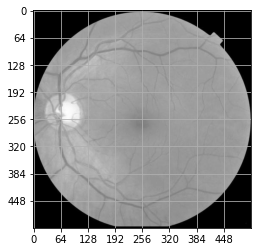

In [62]:
img = cv.imread("/home/guest1/ellen_data/UKB_quality_data2_combined/input_20220221_512/testA/h0001.jpg",0)
print(img.shape)
plt.imshow(img, cmap='gray')

plt.xticks(range(0,512,64))
plt.yticks(range(0,512,64))
plt.grid()

plt.show()